In [ ]:
from pipeline.datasets.dataset_sevir import SEVIRLightningDataModule
dm = SEVIRLightningDataModule(pre)
dm.prepare_data()
dm.setup()

/home/vatsal/miniconda3/envs/earthformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/vatsal/miniconda3/envs/earthformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using catalog filter: None


torch.Size([8, 128, 128, 20])


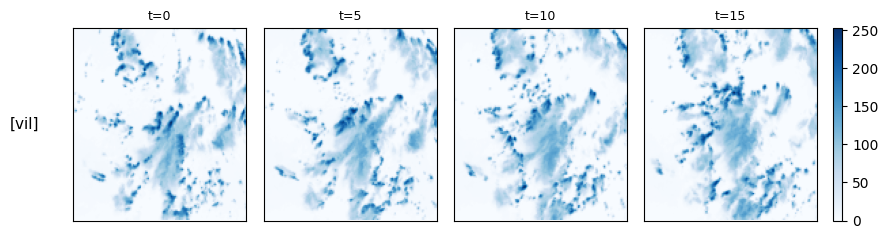

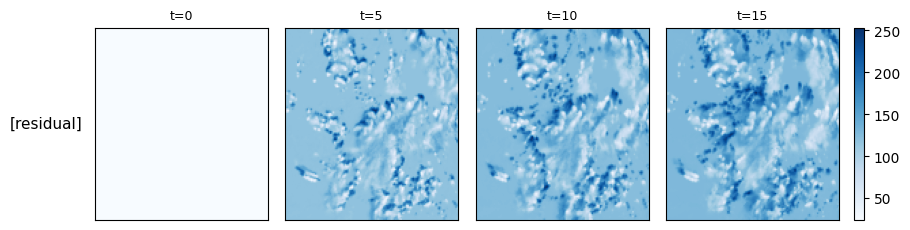

In [ ]:
train_loader = dm.train_dataloader()
for batch in train_loader:
    data = batch['vil']
    print(data.shape)
    data = data.permute(0, 3, 1, 2)
    cmap = 'Blues'
    dm.plot_sample({'vil' : data}, jump = 5, batch_idx=3, cmaps = {'vil' : (cmap, None)})
    frame0 = data[:, 0:1, :, :]
    residual = data - frame0
    residual = (residual + 1) / 2
    dm.plot_sample({'residual': residual}, jump=5, batch_idx=3, cmaps = {'residual' : (cmap, None)})
    break

In [2]:
import os
from pathlib import Path
from collections import defaultdict

def get_dir_size(path):
    total = 0
    for dirpath, _, filenames in os.walk(path, followlinks=False):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            try:
                total += os.path.getsize(fp)
            except (OSError, FileNotFoundError):
                continue
    return total

def find_top_dirs(root_dir, top_n=20):
    dir_sizes = defaultdict(int)
    
    for subdir in Path(root_dir).rglob("*"):
        if subdir.is_dir():
            size = get_dir_size(subdir)
            dir_sizes[str(subdir)] = size

    top_dirs = sorted(dir_sizes.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Top {top_n} directories by size (in GB):")
    for path, size in top_dirs:
        print(f"{path}: {size / (1024**3):.2f} GB")

# Example usage
find_top_dirs("/home/vatsal/NWM/weather")


Top 20 directories by size (in GB):
/home/vatsal/NWM/weather/pipeline: 2.19 GB
/home/vatsal/NWM/weather/DiffCast: 2.01 GB
/home/vatsal/NWM/weather/DiffCast/Exps: 1.88 GB
/home/vatsal/NWM/weather/DiffCast/Exps/basic_exps: 1.88 GB
/home/vatsal/NWM/weather/DiffCast/Exps/basic_exps/Singleearthformer_sevir_None: 1.88 GB
/home/vatsal/NWM/weather/pipeline/logs: 1.87 GB
/home/vatsal/NWM/weather/pipeline/logs/HFUnet3d: 1.53 GB
/home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints: 1.48 GB
/home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None: 1.48 GB
/home/vatsal/NWM/weather/DiffCast/Exps/basic_exps/Singleearthformer_sevir_None/valid_samples: 1.43 GB
/home/vatsal/NWM/weather/DiffCast/Exps/basic_exps/Singleearthformer_sevir_None/valid_samples/sample-9921: 1.24 GB
/home/vatsal/NWM/weather/prediff: 0.86 GB
/home/vatsal/NWM/weather/prediff/pretrained: 0.86 GB
/home/vatsal/NWM/weather/.git: 0.60 GB
/home/vatsal/NWM/weather/.git/objects: 0.60 GB
/home/vatsal/NWM/weather/prediff/pretr

In [4]:
import os
def get_folder_size_in_gb(folder_path):
    """
    Calculate the size of a folder in gigabytes.
    
    Args:
        folder_path (str): Path to the folder.
        
    Returns:
        float: Size of the folder in gigabytes.
    """
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            try:
                total_size += os.path.getsize(fp)
            except (OSError, FileNotFoundError):
                continue
    return total_size / (1024 ** 3)  # Convert bytes to gigabytes

get_folder_size_in_gb("/home/vatsal/NWM/weather")

7.745477132499218

In [ ]:
import torch
for batch in train_loader:
    data = batch['vil']
    print(data.shape)
    data = data.permute(0, 3, 1, 2)
    cmap = 'viridis'
    dm.plot_sample({'vil' : data}, jump = 5, batch_idx=3)
    deltas = []
    for i in range(1, data.shape[1]):
        delta = data[:, i:i+1, :, :] - data[:, 0:1, :, :]
        deltas.append(delta)
    deltas = torch.cat(deltas, dim=1)
    deltas = (deltas + 1) / 2
    dm.plot_sample({'deltas': deltas}, jump=5, batch_idx=3)
    break

In [23]:
config = OmegaConf.load("/home/vatsal/NWM/weather/pipeline/configs/models/vae.yaml")
autoencoder = Autoencoder(config).to("cuda")

['autoencoder_kl', 'lpipsWithDisc']
loaded autoencoder_kl successfully the game is on


In [4]:
from pipeline.datasets.dataset_sevir import SEVIRLightningDataModule
from CasCast.networks.prediff.taming.autoencoder_kl import AutoencoderKL
from pipeline.utils import load_checkpoint_cascast
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.autoencoder = AutoencoderKL(**config)
        self.autoencoder.eval() 
        load_checkpoint_cascast("/home/vatsal/NWM/weather/pipeline/autoencoder_ckpt.pth", self.autoencoder)
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        self.autoencoder.requires_grad_(False)

    @torch.no_grad()
    def encode(self, x):
        # x: (B, T, C, H, W)
        B, T, _, H, W = x.shape
        out = []
        for i in range(T):
            frame = x[:, i]  # (B, C, H, W)
            z = self.autoencoder.encode(frame).sample()
            out.append(z.unsqueeze(1))
        return torch.cat(out, dim=1)

    @torch.no_grad()
    def decode(self, x):
        # x: (B, T, latent_C, H, W)
        B, T, C, H, W = x.shape
        out = []
        for i in range(T):
            frame = x[:, i]
            dec = self.autoencoder.decode(frame)
            out.append(dec.unsqueeze(1))
        return torch.cat(out, dim=1)

from omegaconf import OmegaConf
vae_config = OmegaConf.load("/home/vatsal/NWM/weather/pipeline/configs/models/vae.yaml")
autoencoder = Autoencoder(vae_config).to("cuda")


/home/vatsal/miniconda3/envs/earthformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/vatsal/miniconda3/envs/earthformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['autoencoder_kl', 'lpipsWithDisc']
loaded autoencoder_kl successfully the game is on


In [11]:
path = "/home/vatsal/Dataserver/NWM/datasets/sevir/data/vil/2017"
import os
files = os.listdir(path)
file = files[0]
import h5py
glob_min = float('inf')
glob_max = float('-inf')
data = h5py.File(os.path.join(path, file), 'r')
for i in range(100):
    vil = data['vil'][i]
    # print(vil.shape)  # (T, H, W)
    x = torch.tensor(vil).unsqueeze(0)  # (1, H, W, T)
    x = x.permute(0, 3, 1, 2).unsqueeze(2)  # (1, T, C, H, W)
    x = x.float() / 255.0  # Normalize to [0, 1]
    enc = autoencoder.encode(x.to("cuda"))  # (1, T, latent_C, H', W')
    # print("min enc:", enc.min().item())
    # print("max enc:", enc.max().item())
    # enc *=  0.6786020398139954
    # print("min enc after scaling:", enc.min().item())
    # print("max enc after scaling:", enc.max().item())
    glob_min = min(glob_min, enc.min().item())
    glob_max = max(glob_max, enc.max().item())
print("Global min:", glob_min)
print("Global max:", glob_max)
    

Global min: -11.89787483215332
Global max: 26.66354751586914


In [18]:
path = "/home/vatsal/Dataserver/NWM/datasets/sevir/data/vil/2017"
import os
files = os.listdir(path)
file = files[0]
import h5py
glob_min = float('inf')
glob_max = float('-inf')
data = h5py.File(os.path.join(path, file), 'r')
for i in range(100):
    vil = data['vil'][i]
    # print(vil.shape)  # (T, H, W)
    x = torch.tensor(vil).unsqueeze(0)  # (1, H, W, T)
    x = x.permute(0, 3, 1, 2).unsqueeze(2)  # (1, T, C, H, W)
    x = x.float() / 255.0  # Normalize to [0, 1]
    enc = autoencoder.encode(x.to("cuda"))  # (1, T, latent_C, H', W')
    print("min enc:", enc.min().item())
    print("max enc:", enc.max().item())
    enc = enc * scale + shift
    print("min enc after scaling:", enc.min().item())
    print("max enc after scaling:", enc.max().item())
    if i  > 10:break
    

min enc: -6.627370834350586
max enc: 26.33976936340332
min enc after scaling: 0.13667815923690796
max enc after scaling: 0.9916036128997803
min enc: -8.147011756896973
max enc: 19.869461059570312
min enc after scaling: 0.09726984798908234
max enc after scaling: 0.8238112926483154
min enc: -7.802781105041504
max enc: 21.508934020996094
min enc after scaling: 0.10619665682315826
max enc after scaling: 0.866327166557312
min enc: -6.127824306488037
max enc: 23.393835067749023
min enc after scaling: 0.14963273704051971
max enc after scaling: 0.9152076244354248
min enc: -7.0610432624816895
max enc: 23.384172439575195
min enc after scaling: 0.12543189525604248
max enc after scaling: 0.9149570465087891
min enc: -5.529595851898193
max enc: 23.935745239257812
min enc after scaling: 0.1651463806629181
max enc after scaling: 0.9292608499526978
min enc: -6.625247955322266
max enc: 24.09528160095215
min enc after scaling: 0.13673321902751923
max enc after scaling: 0.9333980083465576
min enc: -7.2546

In [ ]:
scale = 1.0 / (26.66354751586914 - (-11.89787483215332))
#       = 1.0 / 38.561422347 +–≈ 0.02593
shift = -(-11.89787483215332) * scale
#       ≈ 0.30852
scale, shift

(0.0259326533906051, 0.30854346410703587)

In [ ]:
global_min = -11.89787483215332
global_max =  26.66354751586914

scale = 1.0 / (global_max - global_min)
print(scale)  # ≈ 0.025928


0.0259326533906051


In [8]:
outer = (enc.abs() > 1).sum().item()
outer/enc.numel()

0.34778911564625853

min enc: -10.36540412902832
max enc: 22.095224380493164


min enc after scaling: -1.888038992881775
max enc after scaling: 4.02459716796875


In [39]:
dec = autoencoder.decode(enc)  # (1, T, C, H, W)
print("min dec:", dec.min().item())
print("max dec:", dec.max().item())

min dec: -0.004939747042953968
max dec: 0.5534384846687317


In [ ]:
import torch

# Original tensor
x = torch.randn((4, 64, 64))
tmp_x = x.clone()

# 1) Save reference slice
x0 = x[0:1]              # shape (1, 64, 64)

# 2) Subtract x0
x = x - x0               # now centered around zero


# 3) Normalize to [0, 1]
x = (x + 1) / 2

# send

# 4) Rescale back to [-1, 1]
x = x * 2 - 1

# 5) Add x0 back
x = x + x0

# Check
print(torch.isclose(tmp_x, x, atol=1e-5).all())  # Should print: True


tensor(True)


In [1]:
import time
from pathlib import Path

CHECKPOINT_DIRS = [
    Path("/home/vatsal/NWM/weather/pipeline/logs/DiT/checkpoints/scaleshift"),
    Path("/home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None")
]

EXTENSION = ".ckpt"
INTERVAL_SECONDS = 300  # 5 minutes

def delete_all_but_last_ckpt(checkpoint_dir):
    ckpt_files = sorted([f for f in checkpoint_dir.glob(f"*{EXTENSION}") if f.is_file()])
    
    if len(ckpt_files) <= 2:
        print(f"[{checkpoint_dir}] Nothing to delete.")
        return
    
    for ckpt in ckpt_files[:-2]:
        try:
            print(f"Deleting: {ckpt}")
            ckpt.unlink()
        except Exception as e:
            print(f"Error deleting {ckpt}: {e}")

if __name__ == "__main__":
    print(f"Monitoring {len(CHECKPOINT_DIRS)} checkpoint directories every {INTERVAL_SECONDS} seconds...")
    while True:
        for ckpt_dir in CHECKPOINT_DIRS:
            delete_all_but_last_ckpt(ckpt_dir)
        time.sleep(INTERVAL_SECONDS)


Monitoring 2 checkpoint directories every 300 seconds...
[/home/vatsal/NWM/weather/pipeline/logs/DiT/checkpoints/scaleshift] Nothing to delete.
Deleting: /home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None/HFUnet3d-epoch=02-step=013548.ckpt
Deleting: /home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None/HFUnet3d-epoch=03-step=018064.ckpt
Deleting: /home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None/HFUnet3d-epoch=04-step=022580.ckpt
Deleting: /home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None/HFUnet3d-epoch=05-step=027096.ckpt
Deleting: /home/vatsal/NWM/weather/pipeline/logs/HFUnet3d/checkpoints/None/HFUnet3d-epoch=06-step=031612.ckpt


KeyboardInterrupt: 